In [1]:
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
G = nx.read_edgelist("data/barbell.edgelist", encoding='utf-8')

In [3]:
G.edges

EdgeView([('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('1', '2'), ('1', '3'), ('1', '4'), ('1', '5'), ('1', '6'), ('1', '7'), ('1', '8'), ('1', '9'), ('2', '3'), ('2', '4'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('3', '4'), ('3', '5'), ('3', '6'), ('3', '7'), ('3', '8'), ('3', '9'), ('4', '5'), ('4', '6'), ('4', '7'), ('4', '8'), ('4', '9'), ('5', '6'), ('5', '7'), ('5', '8'), ('5', '9'), ('6', '7'), ('6', '8'), ('6', '9'), ('7', '8'), ('7', '9'), ('8', '9'), ('9', '10'), ('10', '11'), ('11', '12'), ('12', '13'), ('13', '14'), ('14', '15'), ('15', '16'), ('16', '17'), ('17', '18'), ('18', '19'), ('19', '20'), ('20', '21'), ('20', '22'), ('20', '23'), ('20', '24'), ('20', '25'), ('20', '26'), ('20', '27'), ('20', '28'), ('20', '29'), ('21', '22'), ('21', '23'), ('21', '24'), ('21', '25'), ('21', '26'), ('21', '27'), ('21', '28'), ('21', '29'), ('22', '23'), ('22', '24'), ('22', '25'), ('22', '26'), ('2

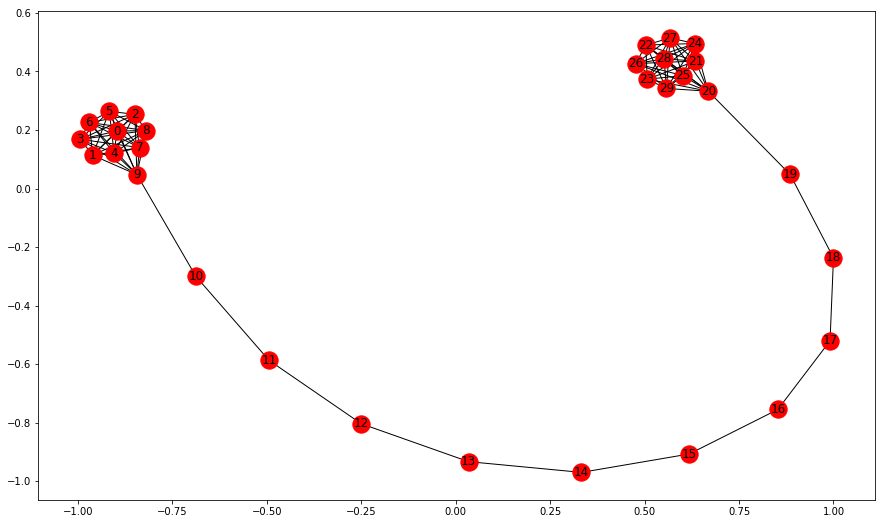

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))
nx.draw_networkx(G, pos=nx.spring_layout(G))

In [23]:
df = pd.read_csv("data/barbell_grau.struc2vec", skiprows=1, sep=' ', header=None, index_col=0).sort_index()

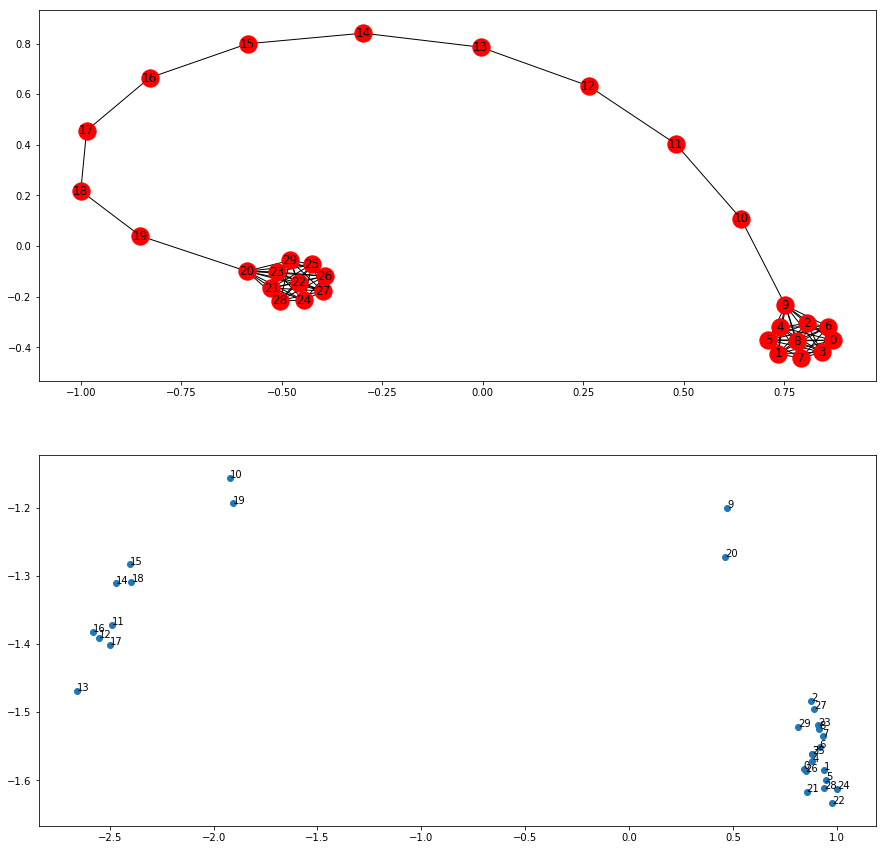

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

ax1=plt.subplot(2, 1, 1)
nx.draw_networkx(G, pos=nx.spring_layout(G))


ax1=plt.subplot(2, 1, 2)
ax1.scatter(df[1], df[2])

for i in df.index:
    ax1.annotate(i, (df.loc[i,1], df.loc[i,2]))

In [25]:
df = pd.read_csv("data/barbell_commonfriends.struc2vec", skiprows=1, sep=' ', header=None, index_col=0).sort_index()

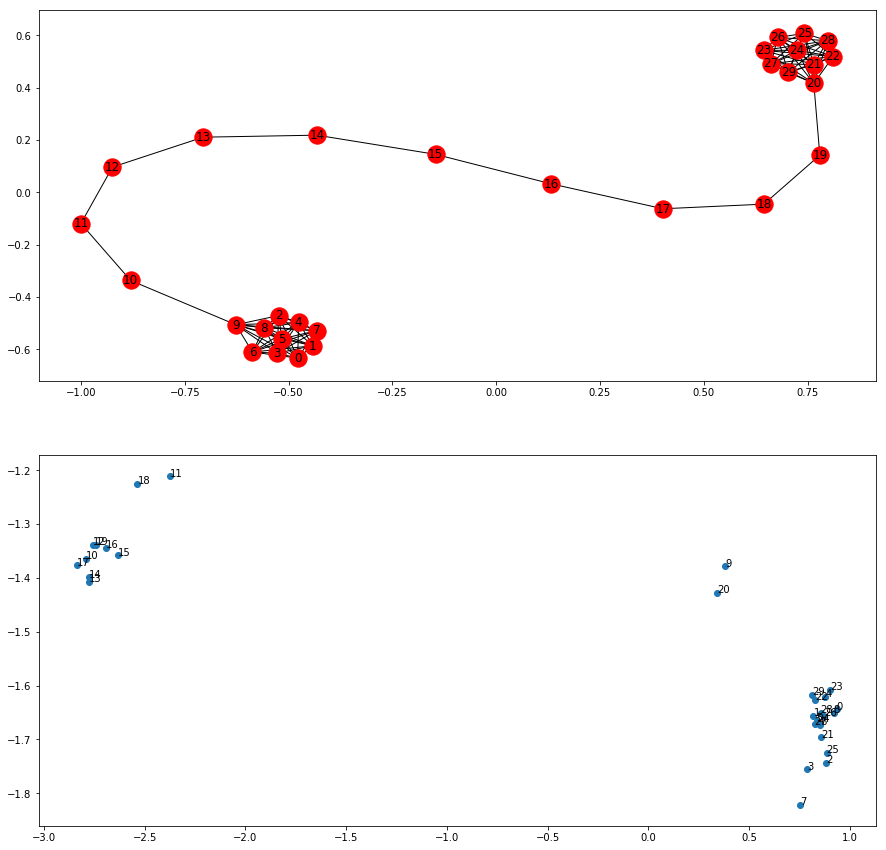

In [26]:
fig, ax = plt.subplots(figsize=(15,15))

ax1=plt.subplot(2, 1, 1)
nx.draw_networkx(G, pos=nx.spring_layout(G))


ax1=plt.subplot(2, 1, 2)
ax1.scatter(df[1], df[2])

for i in df.index:
    ax1.annotate(i, (df.loc[i,1], df.loc[i,2]))